In [1]:
import warnings

warnings.filterwarnings('ignore')
import dynamo as dyn
import numpy as np

In [2]:
filename = './data/NASC-seq/nasc-seq.h5ad'
nasc_seq = dyn.read(filename)

In [4]:
# Set color map according to conditions
color_map = []
i = 0
for (x, y) in zip(nasc_seq.obs.Condition_labelled, nasc_seq.obs.Condition_stimulated):
    if x and y:
        color_map = color_map + ['L;S;' + nasc_seq.obs.time[i]]
    elif x and (not y):
        color_map = color_map + ['L;US;' + nasc_seq.obs.time[i]]
    else:
        color_map = color_map + ['UL;US;' + nasc_seq.obs.time[i]]
    i = i + 1
nasc_seq.obs['Condition'] = color_map

In [5]:
nasc_seq.obs['time'] = nasc_seq.obs['time'].astype(str)
nasc_seq.obs['time'] = nasc_seq.obs['time'].astype(float)

nasc_seq.obs.time = nasc_seq.obs.time / 60  # convert minutes to hours

In [6]:
# read genes with monotonically increasing new/total ratio
temp = np.loadtxt('./data/NASC-seq/nasc-seq_gene.csv', delimiter=',')
index = (temp > 0.01).tolist()
used_genes = nasc_seq.var[index]['Gene_Id'].values.tolist()

In [7]:
dyn.preprocessing.recipe_monocle(
    nasc_seq,
    tkey="time",
    experiment_type="kin",
    keep_filtered_genes=True,
    keep_raw_layers=True,
    genes_to_use=used_genes,
)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: kin
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 575 cells passed basic filters.
|-----> filtering g

In [8]:
# est_method: string (options include twostep, CSP4ML_CSP, CSP4ML_CSZIP)
dyn.tl.dynamics(
    nasc_seq,
    model="deterministic",
    est_method="CSP4ML_CSP",
    # est_method="CSP4ML_CSZIP",
    del_2nd_moments=True,
)

|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [14.5332s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSP, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1718it [00:01, 1308.94it/s]
Infer parameters via Maximum Likelihood Estimation: 116it [00:00, 384.14it/s]

Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 1131it [00:03, 375.85it/s]

Inequality constraints incompatible
Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via Maximum Likelihood Estimation: 1718it [00:04, 372.00it/s]


AnnData object with n_obs × n_vars = 576 × 58428
    obs: 'time', 'Cell_Id', 'Condition_labelled', 'Condition_stimulated', 'exp_type', 'Condition', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr'
    var: 'Gene_Id', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'use_for_dynamics'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics'
    obsm: 'X_pca', 'X'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_n', 'M_CSP_t', 'M_CSP_n', 'velocity_N', 'velocity_T', 'cell_wise_alpha'
    obsp: 'moments_con'

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [5.1518s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

<Figure size 600x400 with 0 Axes>

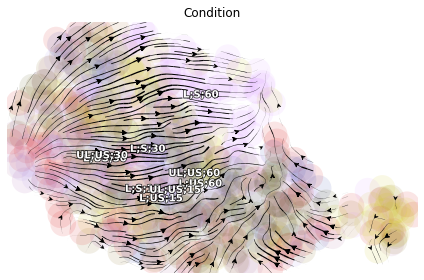

In [9]:
dyn.tl.reduceDimension(nasc_seq, reduction_method='umap')
dyn.tl.cell_velocities(nasc_seq, enforce=True, vkey='velocity_T', ekey='M_t', basis='umap')
dyn.pl.streamline_plot(nasc_seq, color='Condition', basis='umap')